## 1. Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification


from pathlib import Path
import spacy

## 4. Extracting variables

In [9]:
LABEL_COL = 'feeling'
train_df = pd.read_csv(r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\thinking\datasets\balanced_train\balanced_feeling_train.csv")
test_df  = pd.read_csv(r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\thinking\datasets\feeling_test.csv")

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_df["text_lemma"])
y_train = train_df["feeling"]

X_test  = vectorizer.transform(test_df["text_lemma"])
y_test  = test_df["feeling"]


## 5. Train logistic regression model

In [10]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, average='weighted')}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.785143237841439
F1-Score: 0.7748476928949934
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6701
           1       0.61      0.46      0.52      2305

    accuracy                           0.79      9006
   macro avg       0.72      0.68      0.69      9006
weighted avg       0.77      0.79      0.77      9006



## 6. Train linear SVM

In [11]:
svm_model = LinearSVC(max_iter=10000)
param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(svm_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("Linear SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm, average='weighted')}")
print(classification_report(y_test, y_pred_svm))

Linear SVM Results:
Accuracy: 0.7456140350877193
F1-Score: 0.7471727857389862
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      6701
           1       0.50      0.52      0.51      2305

    accuracy                           0.75      9006
   macro avg       0.67      0.67      0.67      9006
weighted avg       0.75      0.75      0.75      9006



In [12]:
from sklearn.model_selection import train_test_split


train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.10,
    random_state=42,
    stratify=train_df[LABEL_COL]
)

print("Train split:", train_split_df.shape)
print("Val split:", val_df.shape)
print("Test:", test_df.shape)


Train split: (27529, 5)
Val split: (3059, 5)
Test: (9006, 5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on: cuda:0


Epoch 1/3: 100%|██████████| 3442/3442 [07:18<00:00,  7.85it/s]


Epoch 1 | train loss=0.5942 | val acc=0.7117 | val F1(w)=0.7153 | val F1(m)=0.6975


Epoch 2/3: 100%|██████████| 3442/3442 [07:29<00:00,  7.65it/s]


Epoch 2 | train loss=0.4950 | val acc=0.7542 | val F1(w)=0.7340 | val F1(m)=0.6989


Epoch 3/3: 100%|██████████| 3442/3442 [07:54<00:00,  7.26it/s]


Epoch 3 | train loss=0.3755 | val acc=0.7306 | val F1(w)=0.7306 | val F1(m)=0.7091

TEST RESULTS
Accuracy: 0.6791028203419942
F1 (weighted): 0.6916169563850159
F1 (macro): 0.614784355763335


## 8. Compare the models, Evaluation and Visualisations


                      Accuracy  Macro-F1  Weighted-F1  Macro-Precision  \
Model                                                                    
Logistic Regression   0.785143  0.692408     0.774848         0.717021   
Linear SVM            0.745614  0.670181     0.747173         0.668204   
Transformer (MiniLM)  0.679103  0.614784     0.691617         0.610779   

                      Macro-Recall  
Model                               
Logistic Regression       0.678877  
Linear SVM                0.672379  
Transformer (MiniLM)      0.629676  

Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6701
           1       0.61      0.46      0.52      2305

    accuracy                           0.79      9006
   macro avg       0.72      0.68      0.69      9006
weighted avg       0.77      0.79      0.77      9006


Linear SVM
              precision    recall  f1-score   support

           0       0.83      

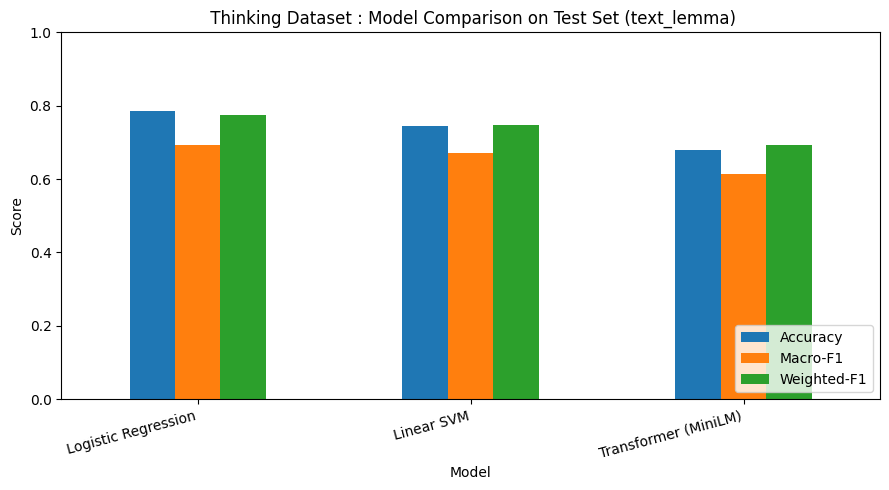

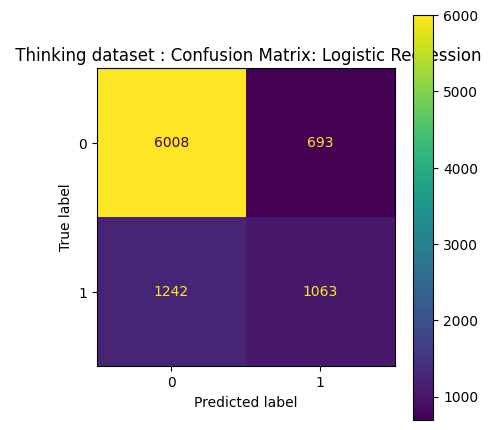

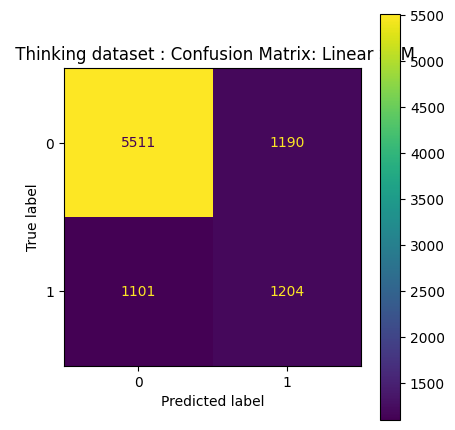

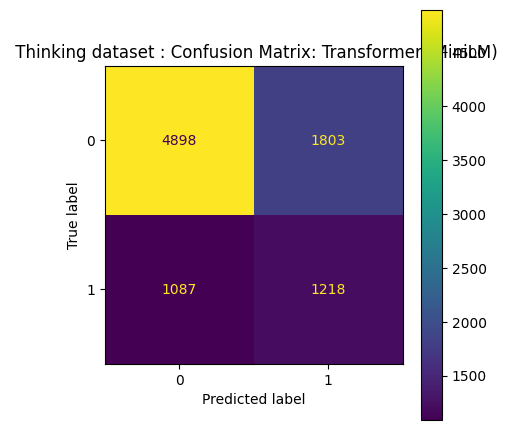


Error overlap summary (counts):
Logistic Regression     1935
Linear SVM              2291
Transformer (MiniLM)    2890
Any_Error               4096
dtype: int64

# cases Transformer correct & LR wrong: 804


In [14]:

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

class_names = ["0", "1"]


# -----------------------
# Metric computation
# -----------------------
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

preds = {
    "Logistic Regression": y_pred_lr,
    "Linear SVM": y_pred_svm,
    "Transformer (MiniLM)": y_pred_minilm,
}

n = len(y_test)
for name, p in preds.items():
    if len(p) != n:
        raise ValueError(f"{name}: y_pred length {len(p)} != y_test length {n}")

# Metrics table
rows = []
for name, y_pred in preds.items():
    row = {"Model": name, **compute_metrics(y_test, y_pred)}
    rows.append(row)

metrics_df = pd.DataFrame(rows).set_index("Model").sort_values("Macro-F1", ascending=False)
print(metrics_df)

# Optional: full per-class report (useful for appendix)
for name, y_pred in preds.items():
    print("\n" + "="*70)
    print(name)
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))



plot_metrics = metrics_df[["Accuracy", "Macro-F1", "Weighted-F1"]]

fig, ax = plt.subplots(figsize=(9, 5))
plot_metrics.plot(kind="bar", ax=ax)
ax.set_title(" Thinking Dataset : Model Comparison on Test Set (text_lemma)")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.legend(loc="lower right")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

for name, y_pred in preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f" Thinking dataset : Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()


err = {}
for name, y_pred in preds.items():
    err[name] = (y_pred != y_test)

err_df = pd.DataFrame({k: v for k, v in err.items()})
err_df["Any_Error"] = err_df.any(axis=1)

print("\nError overlap summary (counts):")
print(err_df.sum())

# Example: cases where transformer is correct but LR is wrong
if "Transformer (MiniLM)" in preds and "Logistic Regression" in preds:
    transf_better = (~err["Transformer (MiniLM)"]) & (err["Logistic Regression"])
    print("\n# cases Transformer correct & LR wrong:", int(transf_better.sum()))
